In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import random

random.seed(42)
np.random.seed(42)

sns.set(style="darkgrid")

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [22]:
X_train = train.iloc[:, 2:].values
y_train = train.iloc[:, 1].values
X_test = test.iloc[:, 1:].values

In [4]:
invlogit = lambda x: 1/(1 + tt.exp(-x))

def get_model(X, y):
    model = pm.Model()
    
    with model:
        a = pm.Normal("activation", mu=0.0, sd=7.0, shape=X.shape[1])
        alpha = pm.Normal("intercept", mu=0.0, sd=3.0)
        beta = pm.Normal("beta", mu=0.0, sd=2.0, shape=X.shape[1])
        coeff = pm.math.switch(X >= a, beta, tt.zeros(X.shape[1]))
        p = tt.dot(X, coeff.T)
        y_obs = pm.Bernoulli('y_obs', invlogit(alpha + p),  observed=y)
    
    return model

In [6]:
model1 = get_model(X_train, y_train)

In [7]:
for RV in model1.basic_RVs:
    print(RV.name, RV.logp(model1.test_point))

activation -859.4546046779991
intercept -2.0175508218727827
beta -483.62571412938354
y_obs -43321.69878493604


In [8]:
with model1:
    trace = pm.sample(2000, step=pm.Metropolis(), random_seed=4816, cores=1, progressbar=True, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [beta]
>Metropolis: [intercept]
>Metropolis: [activation]
100%|██████████| 2500/2500 [02:14<00:00, 18.65it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


/home/twillard/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/twillard/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/twillard/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ce2261240>,
      dtype=object)

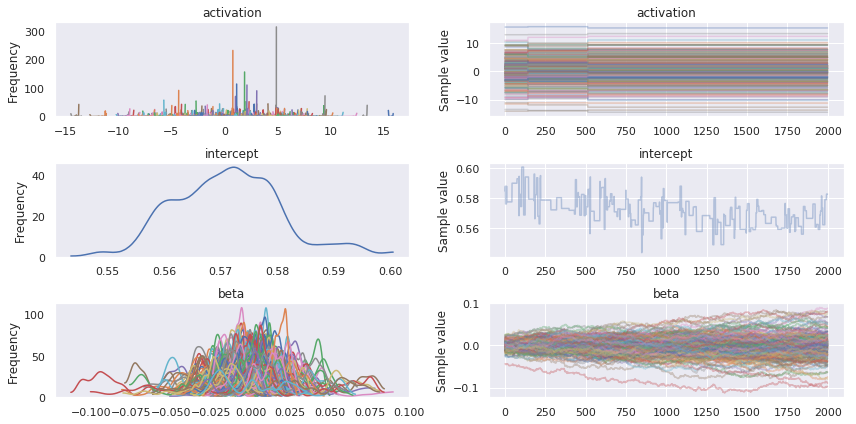

In [9]:
pm.traceplot(trace)

In [10]:
model2 = get_model(X_train, y_train)

with model2:
    trace = pm.sample(4000, step=pm.Metropolis(), random_seed=4816, cores=1, progressbar=True, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [beta]
>Metropolis: [intercept]
>Metropolis: [activation]
100%|██████████| 4500/4500 [02:48<00:00, 27.24it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


/home/twillard/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/twillard/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/twillard/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ce3ece668>,
      dtype=object)

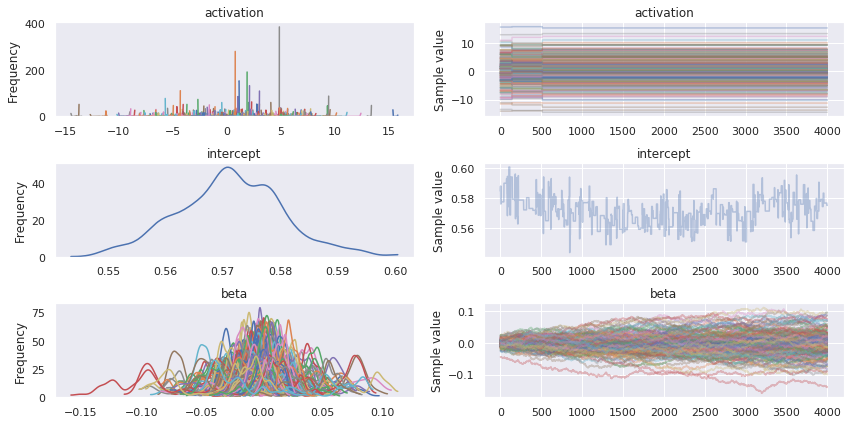

In [11]:
pm.traceplot(trace)

In [40]:
activation = np.apply_along_axis(np.mean, 0, trace["activation"])
beta = np.apply_along_axis(np.mean, 0, trace["beta"])
intercept = trace["intercept"].mean()

def predict(X):
    coeff = np.where(X >= activation, beta, 0.0)
    p = np.dot(X_test, coeff.T)
    return 1.0/(1.0 + np.exp(-intercept - p))

In [41]:
predict(X_test)

MemoryError: 